In [50]:
from typing import Optional, TypeVar, Callable, Optional
import os
import pickle
import warnings
import pandas as pd
from qlib.backtest import backtest, executor as exec
from qlib.contrib.evaluate import risk_analysis
from qlib.contrib.report.analysis_position import report_graph
from alphagen.data.expression import *

from alphagen_qlib.stock_data import StockData, StockDataLP
from alphagen_generic.features import *
from alphagen_qlib.strategy import TopKSwapNStrategy
from datetime import datetime
import joblib
from qlib.data.dataset.processor import ZScoreNorm, Fillna, DropnaProcessor, MinMaxNorm, CSZFillna
import seaborn as sns
import xgboost as xgb

from qlib.data.dataset.loader import QlibDataLoader
from qlib.data import D
import qlib
from qlib.config import REG_CN
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset import DatasetH, TSDatasetH
from qlib.contrib.data.handler import Alpha158, check_transform_proc
import matplotlib.pyplot as plt
qlib.init(provider_uri="~/.qlib/qlib_data/cn_data_rolling", region=REG_CN)

[69088:MainThread](2024-01-04 20:42:58,318) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[69088:MainThread](2024-01-04 20:42:58,320) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[69088:MainThread](2024-01-04 20:42:58,321) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/Users/yangguangyu/.qlib/qlib_data/cn_data_rolling')}


In [27]:
FEATURE_SET = [
    '$open', '$close', '$high', '$low', '$volume', \
    '$vwap', '$amount', '$isst', '$pbmrq', '$pcfncfttm', '$pctchg', '$pettm', \
    '$preclose', '$psttm', '$turn'
]
INSTRUMENTS = "hs300"
DEVICE = "cpu"
START_TIME = "2015-01-01"
END_TIME = "2023-06-30"
FIT_START_TIME = "2000-01-01"
FIT_END_TIME = "2011-12-31"
DATASET_SEGMENTS = {
    "train": ("2015-01-01", "2018-12-31"),
    "valid": ("2019-01-01", "2019-12-31"),
    "test": ("2020-01-01", "2023-06-30"),
}
FREQ = "day"
# LABEL_EXP = "Ref($close, -5)"

# close = Feature(FeatureType.CLOSE)
# target = Ref(close, -20) / close - 1

# minmax_proc = MinMaxNorm(fit_start_time="2015-01-01", fit_end_time='2018-12-31')
# dropna_proc = DropnaProcessor()
# csfillna_proc = CSZFillna()
# # learn_processors = [dropna_proc, minmax_proc]
# # infer_processors = [csfillna_proc, dropna_proc, minmax_proc]

# learn_processors, infer_processors = [], []


# data_train = StockDataLP(instrument=INSTRUMENTS,
#                          start_time='2015-01-01',
#                          end_time='2018-12-31',
#                          device=DEVICE,
#                          processors=learn_processors,
#                         for_train=True)
# data_valid = StockDataLP(instrument=instruments,
#                          start_time='2019-01-01',
#                          end_time='2019-12-31',
#                          device=DEVICE,
#                          processors=infer_processors)
# data_test = StockDataLP(instrument=INSTRUMENTS,
#                         start_time='2020-01-01',
#                         end_time='2023-06-30',
#                         device=DEVICE,
#                         processors=infer_processors)

# df['price_change_in_20_days'] = df['close'].shift(-20) - df['close']

In [35]:
def get_seg_dataset(dataset, combine=True):
    test_set = dataset.handler.fetch(DATASET_SEGMENTS["test"])
    valid_set = dataset.handler.fetch(DATASET_SEGMENTS["valid"])
    if combine:
        train_st, _ = DATASET_SEGMENTS["train"]
        _, valid_ed = DATASET_SEGMENTS["valid"]
        train_set = dataset.handler.fetch((train_st, valid_ed))
    else:
        train_set = dataset.handler.fetch(DATASET_SEGMENTS["train"])
    return train_set, valid_set, test_set

class CustomizedHandler(DataHandlerLP):
    def __init__(
        self,
        instruments="csi500",
        start_time=None,
        end_time=None,
        freq="day",
        infer_processors=[],
        learn_processors=[],
        fit_start_time=None,
        fit_end_time=None,
        process_type=DataHandlerLP.PTYPE_A,
        filter_pipe=None,
        inst_processors=None,
        **kwargs
    ):
        infer_processors = check_transform_proc(infer_processors, fit_start_time, fit_end_time)
        learn_processors = check_transform_proc(learn_processors, fit_start_time, fit_end_time)

        data_loader = {
            "class": "QlibDataLoader",
            "kwargs": {
                "config": {
                    "feature": FEATURE_SET, 
                    "label": kwargs.pop("label", self.get_label_config()),
                },
                "filter_pipe": filter_pipe,
                "freq": freq,
                "inst_processors": inst_processors,
            },
        }
        super().__init__(
            instruments=instruments,
            start_time=start_time,
            end_time=end_time,
            data_loader=data_loader,
            infer_processors=infer_processors,
            learn_processors=learn_processors,
            process_type=process_type,
            **kwargs
        )
    
    def get_label_config(self):
        fields, names = ["Ref($close, -20) / $close - 1"], ["$target"]
        return fields, names 

In [46]:

handler_kwargs = {
    "start_time": START_TIME,
    "end_time": END_TIME,
    "fit_start_time": FIT_START_TIME,
    "fit_end_time": FIT_END_TIME,
    "instruments": INSTRUMENTS,
    "freq": FREQ,
    "infer_processors": [
        {
            "class": "CSZFillna",
        },
        
    ],
    "learn_processors": [
        {"class": "DropnaProcessor"},
    ],
    
}

handler = CustomizedHandler(**handler_kwargs)
dataset = DatasetH(
    handler=handler,
    segments=DATASET_SEGMENTS
)

train_set, valid_set, test_set = get_seg_dataset(dataset, combine=False)
# 预处理后数据的nan检验
nan_count = train_set.isna().sum()
nan_index_cnt_map = {}
for index, value in nan_count.iteritems():
    if value != 0:
        nan_index_cnt_map[index] = value
print(f"NAN feature Map: {nan_index_cnt_map}")
_datasets = dataset.prepare(["train", "valid", "test"])
cols = list(train_set.columns)
print(f"\n data features: {cols}")
print(f"\n train set: {len(train_set)}, valid set: {len(valid_set)}, test set: {len(test_set)}\n")

[69088:MainThread](2024-01-04 20:42:11,849) INFO - qlib.timer - [log.py:127] - Time cost: 14.221s | Loading data Done
[69088:MainThread](2024-01-04 20:42:17,736) INFO - qlib.timer - [log.py:127] - Time cost: 5.861s | CSZFillna Done
[69088:MainThread](2024-01-04 20:42:17,766) INFO - qlib.timer - [log.py:127] - Time cost: 0.030s | DropnaProcessor Done
[69088:MainThread](2024-01-04 20:42:17,771) INFO - qlib.timer - [log.py:127] - Time cost: 5.920s | fit & process data Done
[69088:MainThread](2024-01-04 20:42:17,793) INFO - qlib.timer - [log.py:127] - Time cost: 20.165s | Init data Done


NAN feature Map: {}

 data features: ['$open', '$close', '$high', '$low', '$volume', '$vwap', '$amount', '$isst', '$pbmrq', '$pcfncfttm', '$pctchg', '$pettm', '$preclose', '$psttm', '$turn', '$target']

 train set: 223927, valid set: 62780, test set: 225660



/var/folders/xj/8b3m4m7n4xsgjxqhl9c106k40000gn/T/ipykernel_69088/2772284571.py:30: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [34]:
train_set

$open      $close       $high        $low  \
datetime   instrument                                                   
2015-01-05 SH600000     59.252041   59.960976   60.632599   58.058044   
           SH600009     22.770130   23.585812   24.022373   22.770130   
           SH600010      8.285518    8.771709    8.791967    8.184227   
           SH600011     10.709764   11.250662   11.370861   10.625626   
           SH600015     20.076738   20.047127   20.491302   19.543728   
...                           ...         ...         ...         ...   
2018-12-28 SZ300628    157.257355  157.055115  158.147186  153.495804   
           SZ300661     88.214539   89.519485   89.871826   87.170578   
           SZ300750     75.690002   73.800003   76.620003   73.800003   
           SZ300751    116.219849  119.125343  119.483551  115.672577   
           SZ300760    106.772209  108.480568  108.887787  105.580338   

                            $volume       $vwap       $amount  $isst  \
datetime   instrument                                                  
2015-01-05 SH600000    1.376403e+08   59.450745  8.182821e+09    0.0   
           SH600009    3.233553e+07   23.503975  7.600136e+08    0.0   
           SH600010    3.112319e+08    8.583900  2.671583e+09    0.0   
           SH600011    1.236464e+08   11.035011  1.364439e+09    0.0   
           SH600015    1.573916e+08   20.063738  3.157864e+09    0.0   
...                             ...         ...           ...    ...   
2018-12-28 SZ300628    8.533159e+05  156.069153  1.331763e+08    0.0   
           SZ300661    2.265468e+05   89.186378  2.020489e+07    0.0   
           SZ300750    5.629239e+06   75.337387  4.240922e+08    0.0   
           SZ300751    9.386926e+05  117.742935  1.105244e+08    0.0   
           SZ300760    3.275227e+06  107.849403  3.532313e+08    0.0   

                          $pbmrq  $pcfncfttm   $pctchg      $pettm  \
datetime   instrument                                                
2015-01-05 SH600000     1.295783   -9.848905  2.421900    6.530320   
           SH600009     2.204446   18.158615  4.638100   19.894686   
           SH600010     3.685936   29.890118  6.127500  610.165771   
           SH600011     2.020757 -109.665070  6.002300   11.914085   
           SH600015     1.252455  -30.331793  0.594400    6.868847   
...                          ...         ...       ...         ...   
2018-12-28 SZ300628     6.996667 -190.402649  0.000000   29.945515   
           SZ300661     6.613455   44.898109  1.479290   50.985905   
           SZ300750     5.015039  294.632385 -2.612821   42.856148   
           SZ300751    13.841834   66.237892  2.543898   37.866570   
           SZ300760    15.477773   71.210289  1.590549   38.025154   

                        $preclose     $psttm     $turn    LABEL0  
datetime   instrument                                             
2015-01-05 SH600000     58.543106   2.555270  3.441509 -0.126322  
           SH600009     22.540361   7.060671  3.397289 -0.023380  
           SH600010      8.265260   2.224661  4.005160  0.230947  
           SH600011     10.613605   1.044515  1.415449 -0.146367  
           SH600015     19.928680   2.289007  3.591908 -0.120384  
...                           ...        ...       ...       ...  
2018-12-28 SZ300628    157.055115  14.159737  2.310789 -0.015323  
           SZ300661     88.214539   9.128003  0.697287  0.062974  
           SZ300750     75.779999   5.963956  2.591209  0.039024  
           SZ300751    116.170090   9.027592  7.184846  0.385316  
           SZ300760    106.782143  10.128995  2.675208 -0.047977  

[223927 rows x 16 columns]

In [12]:
# df = QlibDataLoader(config=FEATURE_SET).load("hs300", '2015-01-01', '2018-12-31')
# df['$target'] = df['$close'].shift(-20) - df['$close']
# df

$open      $close       $high        $low  \
datetime   instrument                                                   
2015-01-05 SH600000     59.252041   59.960976   60.632599   58.058044   
           SH600009     22.770130   23.585812   24.022373   22.770130   
           SH600010      8.285518    8.771709    8.791967    8.184227   
           SH600011     10.709764   11.250662   11.370861   10.625626   
           SH600015     20.076738   20.047127   20.491302   19.543728   
...                           ...         ...         ...         ...   
2018-12-28 SZ300628    157.257355  157.055115  158.147186  153.495804   
           SZ300661     88.214539   89.519485   89.871826   87.170578   
           SZ300750     75.690002   73.800003   76.620003   73.800003   
           SZ300751    116.219849  119.125343  119.483551  115.672577   
           SZ300760    106.772209  108.480568  108.887787  105.580338   

                            $volume       $vwap       $amount  $isst  \
datetime   instrument                                                  
2015-01-05 SH600000    1.376403e+08   59.450745  8.182821e+09    0.0   
           SH600009    3.233553e+07   23.503975  7.600136e+08    0.0   
           SH600010    3.112319e+08    8.583900  2.671583e+09    0.0   
           SH600011    1.236464e+08   11.035011  1.364439e+09    0.0   
           SH600015    1.573916e+08   20.063738  3.157864e+09    0.0   
...                             ...         ...           ...    ...   
2018-12-28 SZ300628    8.533159e+05  156.069153  1.331763e+08    0.0   
           SZ300661    2.265468e+05   89.186378  2.020489e+07    0.0   
           SZ300750    5.629239e+06   75.337387  4.240922e+08    0.0   
           SZ300751    9.386926e+05  117.742935  1.105244e+08    0.0   
           SZ300760    3.275227e+06  107.849403  3.532313e+08    0.0   

                          $pbmrq  $pcfncfttm   $pctchg      $pettm  \
datetime   instrument                                                
2015-01-05 SH600000     1.295783   -9.848905  2.421900    6.530320   
           SH600009     2.204446   18.158615  4.638100   19.894686   
           SH600010     3.685936   29.890118  6.127500  610.165771   
           SH600011     2.020757 -109.665070  6.002300   11.914085   
           SH600015     1.252455  -30.331793  0.594400    6.868847   
...                          ...         ...       ...         ...   
2018-12-28 SZ300628     6.996667 -190.402649  0.000000   29.945515   
           SZ300661     6.613455   44.898109  1.479290   50.985905   
           SZ300750     5.015039  294.632385 -2.612821   42.856148   
           SZ300751    13.841834   66.237892  2.543898   37.866570   
           SZ300760    15.477773   71.210289  1.590549   38.025154   

                        $preclose     $psttm     $turn     $target  
datetime   instrument                                               
2015-01-05 SH600000     58.543106   2.555270  3.441509  -21.220936  
           SH600009     22.540361   7.060671  3.397289  152.055511  
           SH600010      8.265260   2.224661  4.005160   -3.221709  
           SH600011     10.613605   1.044515  1.415449   21.753000  
           SH600015     19.928680   2.289007  3.591908   61.670769  
...                           ...        ...       ...         ...  
2018-12-28 SZ300628    157.055115  14.159737  2.310789         NaN  
           SZ300661     88.214539   9.128003  0.697287         NaN  
           SZ300750     75.779999   5.963956  2.591209         NaN  
           SZ300751    116.170090   9.027592  7.184846         NaN  
           SZ300760    106.782143  10.128995  2.675208         NaN  

[223927 rows x 16 columns]

## 特征选择

In [47]:
# 搞xgboost的数据
train_data = train_set.copy()
test_data = test_set.copy()

# features, labels = get_feature_and_label_list(train_data)


y_train = train_data["$target"]
X_train = train_data.drop("$target", axis=1)

y_test = test_data["$target"]
X_test = test_data.drop("$target", axis=1)


In [48]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
evals_result = regressor.evals_result()
evals_result

{'validation_0': OrderedDict([('rmse',
               [0.6695536918556539,
                0.6375197454125526,
                0.6071288910003927,
                0.5783449397577934,
                0.5510671783474416,
                0.5252271673094142,
                0.5007600647338429,
                0.47760807028686647,
                0.4556726408302346,
                0.43495611568039827,
                0.4153768678040393,
                0.3968466712942395,
                0.37935932099221875,
                0.3628182081190901,
                0.34722924897131974,
                0.33251906704607626,
                0.3186718402856162,
                0.30561382972432793,
                0.29333378778358665,
                0.2817994952553972,
                0.2709335104030207,
                0.26073802770383275,
                0.2511074358490849,
                0.2421425637313599,
                0.23375246363666552,
                0.2258417669685333,
                

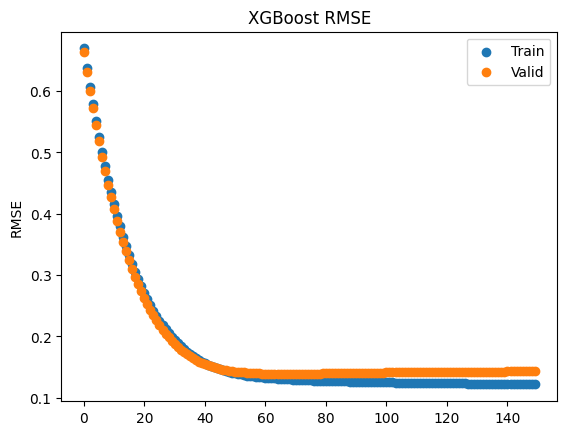

In [51]:
# 绘制一下train valid 的loss
train_loss = evals_result['validation_0']['rmse']
valid_loss = evals_result['validation_1']['rmse']


epochs = len(train_loss)
x_axis = range(0, epochs)

plt.scatter(x_axis, train_loss, label='Train')
plt.scatter(x_axis, valid_loss, label='Valid')
plt.legend()

plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

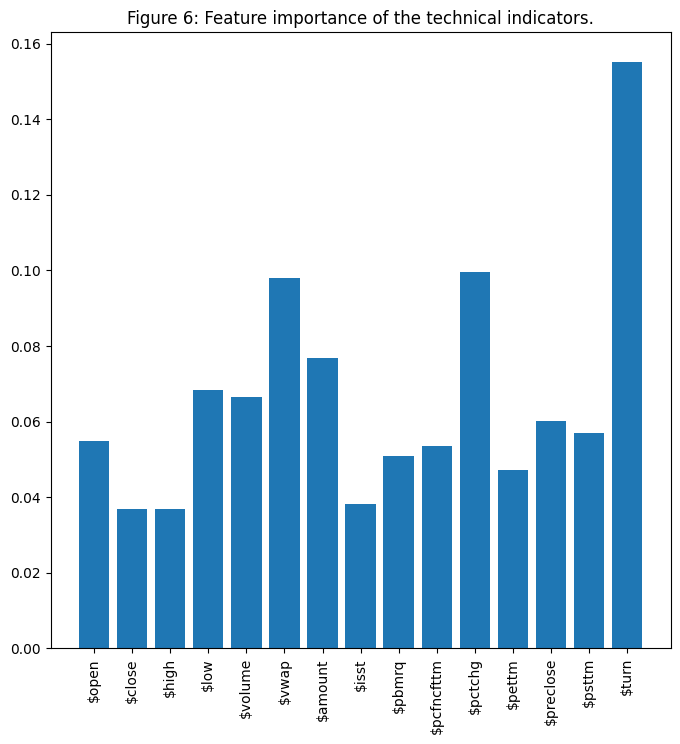

In [52]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()